--------------------------------
# LoanTap: Logistic Regression
--------------------------------

## Defining Problem Statement & Exploratory Data Analysis

### Problem Statement:

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.
Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

### Importing Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE
from collections import Counter



import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
#pip install imbalanced-learn

### Importing Data & removing non-relevant columns / duplicates

In [39]:
raw_data = pd.read_csv('logistic_regression.csv')
raw_data.drop_duplicates(keep='last')
raw_data.columns = raw_data.columns.str.strip()
print('-'*50)
print(f'Shape of Data : {raw_data.shape}')
print('-'*50)
raw_data.sample(100).head()

--------------------------------------------------
Shape of Data : (396030, 27)
--------------------------------------------------


loan_amnt        term  int_rate  installment grade sub_grade  \
319464    24525.0   36 months     19.24       901.97     E        E2   
22295     12000.0   36 months     11.67       396.69     B        B4   
206266     9200.0   36 months     16.55       325.95     D        D2   
231202     4600.0   36 months     20.99       173.29     E        E5   
29938     15000.0   36 months     11.14       492.08     B        B2   

                  emp_title emp_length home_ownership  annual_inc  ...  \
319464  Executive Assistant  10+ years           RENT    100000.0  ...   
22295            Supervisor  10+ years       MORTGAGE     61600.0  ...   
206266                parts  10+ years           RENT     57000.0  ...   
231202     District Manager    2 years       MORTGAGE     54000.0  ...   
29938            Rehab Care   < 1 year       MORTGAGE     70000.0  ...   

       open_acc pub_rec revol_bal revol_util total_acc  initial_list_status  \
319464     24.0     0.0   16633.0       64.2      45.0                    f   
22295      22.0     0.0    5750.0       30.0      31.0                    w   
206266     14.0     0.0    6009.0       34.0      33.0                    f   
231202      7.0     1.0     670.0       44.7      29.0                    f   
29938      15.0     0.0   18334.0       42.8      23.0                    w   

       application_type  mort_acc  pub_rec_bankruptcies  \
319464       INDIVIDUAL       0.0                   0.0   
22295        INDIVIDUAL       1.0                   0.0   
206266       INDIVIDUAL       0.0                   0.0   
231202       INDIVIDUAL       5.0                   1.0   
29938        INDIVIDUAL       2.0                   0.0   

                                                  address  
319464   783 David Roads Apt. 197\r\nNew Arthur, KS 00813  
22295          067 Emma Walks\r\nWest Amberport, MI 70466  
206266        67883 Margaret Route\r\nNew David, MI 11650  
231202            527 Ortega Mall\r\nPort Kelly, WV 70466  
29938   20911 Alan Valleys\r\nWest Jonathanburgh, NC 2...  

[5 rows x 27 columns]

In [10]:
#Creating copy of raw_data
data = raw_data.copy(deep = True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

### Exploratory Data Analysis and Feature Engineering

In [5]:
#finding percentage of null values in data
#np.round(data.isnull().sum()*100 / len(data), 2)

missing_data = pd.DataFrame(data.isnull().sum()/data.shape[0] * 100, columns= ['Missing_Percent'])
missing_data = missing_data.loc[missing_data.Missing_Percent > 0]
missing_data.sort_values(by='Missing_Percent', ascending=False)

Missing_Percent
mort_acc                     9.543469
emp_title                    5.789208
emp_length                   4.621115
title                        0.443148
pub_rec_bankruptcies         0.135091
revol_util                   0.069692

=> There are 6 features with missing values in the dataset. 'mort_acc' have around 10% of observations with missing values, followed by 'emp_title' (6%) and 'emp_length' (5%). 'title' , 'pub_rec_bankruptcies' and 'revol_util' have less than 0.5% missing values.

=> Since we have significant amount of clean data available, we will go ahead and drop these rows (with missing values)

In [11]:
#dropping null values and non-relevant columns
data.dropna(inplace=True)

### Creating New/ Derived Columns

In [12]:
#creating 'state' & 'pincode' from 'address'
def get_state(address):
    state = address.split()[-2]    
    return state

def get_pincode(address):
    pincode = address.split()[-1]
    return pincode

data['state'] = data['address'].apply(get_state)
data['pincode'] = data['address'].apply(get_pincode)
data = data.drop(columns=['address'])

In [13]:
#Creating Credit_line_months = months(earliest_cr_line - issue_d)
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['Credit_line_months'] = ((data['issue_d'] - data['earliest_cr_line']) / np.timedelta64(1, 'M'))
data['Credit_line_months'] = data['Credit_line_months'].astype(np.int64)
data['Credit_line_months']
data = data.drop(columns=['issue_d', 'earliest_cr_line'])

In [14]:
#Modifying pub_rec, pub_rec_bankruptcies, mort_acc into 0 or 1
def convert_binary(value):
    if value == 0 : return 0
    elif value >=1: return 1
    else: return np.nan

data['pub_rec'] = data['pub_rec'].apply(convert_binary)
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(convert_binary)
data['mort_acc'] = data['mort_acc'].apply(convert_binary)

In [15]:
#Modifying emp_title
top10_emp_title = raw_data['emp_title'].value_counts().head(10).index
data['emp_title'] = data['emp_title'].apply(lambda x: x if x in top10_emp_title else 'Others')

In [16]:
#Modifying Column title
top10_title = raw_data['title'].value_counts().head(10).index
data['title'] = data['title'].apply(lambda x: x if x in top10_title else 'Others')

In [17]:
print('-'*50)
print(f'Shape of Data : {data.shape}')
print('-'*50)
print(f'Percentage distribution of Target Variable : ')
print(np.round(data['loan_status'].value_counts(normalize=True) *100, 2))
print('-'*50)
#Target variable distribution is 80%-20%. Data is significantly imbalanced

--------------------------------------------------
Shape of Data : (335868, 27)
--------------------------------------------------
Percentage distribution of Target Variable : 
Fully Paid     80.26
Charged Off    19.74
Name: loan_status, dtype: float64
--------------------------------------------------


### Outlier Detection & Removal

In [14]:
data.describe(include = ['float64', 'int64'], percentiles=[.25,.5,.75,.90,.95, .99, .999]).round(2).T

count      mean       std      min       25%  \
loan_amnt             335868.0  14522.75   8386.59  1000.00   8000.00   
int_rate              335868.0     13.80      4.51     5.32     10.64   
installment           335868.0    445.16    251.59    28.75    263.78   
annual_inc            335868.0  75817.16  61972.19  5000.00  47000.00   
dti                   335868.0     17.72      8.15     0.00     11.63   
open_acc              335868.0     11.60      5.18     1.00      8.00   
pub_rec               335868.0      0.15      0.36     0.00      0.00   
revol_bal             335868.0  16193.06  20990.69     0.00   6302.00   
revol_util            335868.0     54.37     23.96     0.00     36.90   
total_acc             335868.0     25.86     11.90     2.00     17.00   
mort_acc              335868.0      0.61      0.49     0.00      0.00   
pub_rec_bankruptcies  335868.0      0.12      0.32     0.00      0.00   
Credit_line_months    335868.0    187.81     83.24    36.00    132.00   

                           50%       75%        90%        95%        99%  \
loan_amnt             12400.00  20000.00   27250.00   32000.00   35000.00   
int_rate                 13.35     16.78      19.72      21.99      25.57   
installment             388.20    583.79     797.03     942.56    1207.30   
annual_inc            65000.00  90000.00  124800.00  150000.00  250000.00   
dti                      17.25     23.42      28.87      31.86      36.61   
open_acc                 11.00     14.00      18.00      21.00      28.00   
pub_rec                   0.00      0.00       1.00       1.00       1.00   
revol_bal             11480.00  19990.25   31848.00   41326.65   86527.65   
revol_util               55.30     73.00      86.10      91.90      98.00   
total_acc                24.00     33.00      42.00      48.00      61.00   
mort_acc                  1.00      1.00       1.00       1.00       1.00   
pub_rec_bankruptcies      0.00      0.00       1.00       1.00       1.00   
Credit_line_months      172.00    231.00     302.00     347.00     445.00   

                          99.9%         max  
loan_amnt              35000.00    40000.00  
int_rate                  28.14       30.99  
installment             1318.45     1533.81  
annual_inc            500000.00  8706582.00  
dti                       39.85      380.53  
open_acc                  38.00       90.00  
pub_rec                    1.00        1.00  
revol_bal             257083.59  1743266.00  
revol_util               102.50      892.30  
total_acc                 78.00      151.00  
mort_acc                   1.00        1.00  
pub_rec_bankruptcies       1.00        1.00  
Credit_line_months       562.00      841.00

In [18]:
#Columns identified to have Outliers
outlier_columns = ['annual_inc', 'dti', 'open_acc','revol_bal','revol_util', 
                   'total_acc', 'Credit_line_months' ]

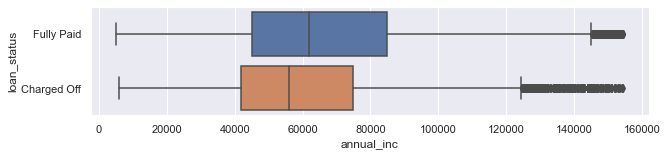

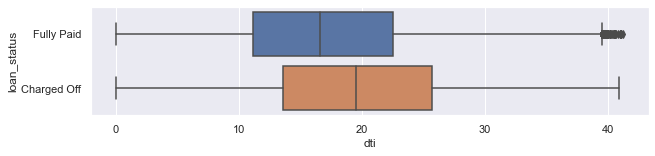

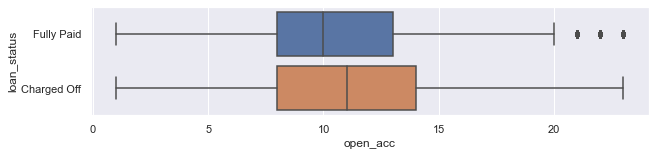

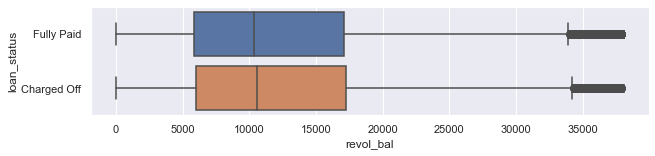

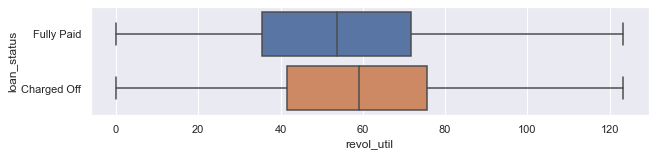

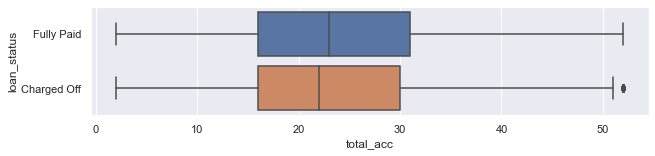

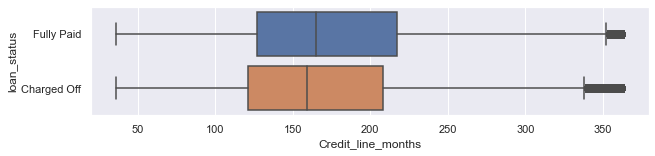

In [21]:
#Checking Box-plots of Columns with Outliers
loan_status = data['loan_status'].astype('str')


for outlier in outlier_columns:
    plt.figure(figsize=(10,2))
    sns.boxplot(x = data[outlier], y = loan_status)
    plt.show()

In [19]:
#Removing outliers from Columns
for outlier in outlier_columns:   
    Q1 = data[outlier].quantile(0.25)
    Q3 = data[outlier].quantile(0.75)
    IQR = Q3-Q1
    low = Q1-(1.5*IQR)
    up = Q3+(1.5*IQR)

    data = data.loc[(data[outlier] >= low) & (data[outlier] <= up)]

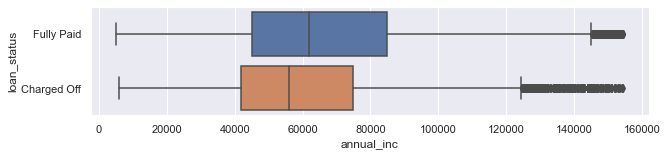

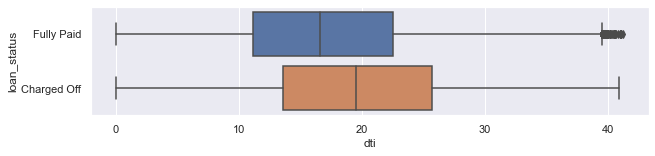

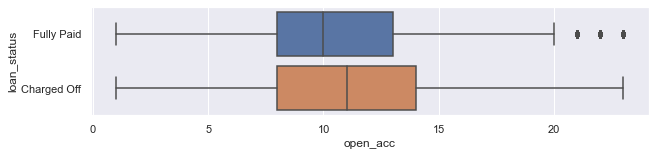

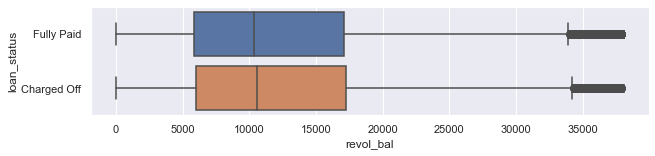

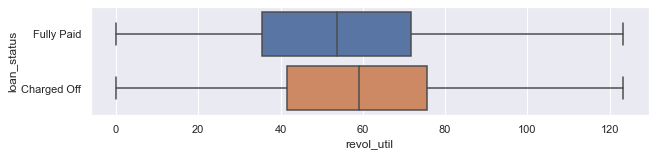

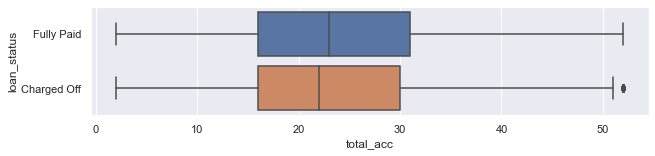

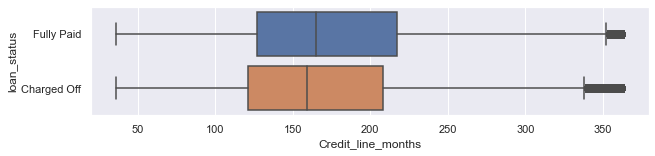

In [22]:
#Ploting Box-plot after removing Outliers
for outlier in outlier_columns:
    plt.figure(figsize=(10,2))
    sns.boxplot(x = data[outlier], y = loan_status)
    plt.show()

In [23]:
print('-'*50)
print(f'Shape of Data : {data.shape}')
print('-'*50)
print(f'Percentage distribution of Target Variable : ')
print(np.round(data['loan_status'].value_counts(normalize=True) *100, 2))
print('-'*50)
#Target variable distribution is 80%-20%. Data is significantly imbalanced

--------------------------------------------------
Shape of Data : (281555, 27)
--------------------------------------------------
Percentage distribution of Target Variable : 
Fully Paid     79.94
Charged Off    20.06
Name: loan_status, dtype: float64
--------------------------------------------------


### Univariate Analysis

In [24]:
hist_columns1 = ['loan_amnt', 'int_rate', 'installment','annual_inc','dti','open_acc', 'Credit_line_months']
hist_columns2 =  ['revol_bal','revol_util','total_acc','mort_acc', 'pub_rec', 'pub_rec_bankruptcies']
hist_columns = hist_columns1 + hist_columns2


countplot_columns1= ['term','loan_status','home_ownership','verification_status','initial_list_status','application_type']
countplot_columns2 = ['grade','sub_grade','purpose', 'emp_length']

countplot_columns = countplot_columns1 + countplot_columns2

----------------------------------------------------------------------
Univariate Analysis - Histograms of Continuous Variables
----------------------------------------------------------------------


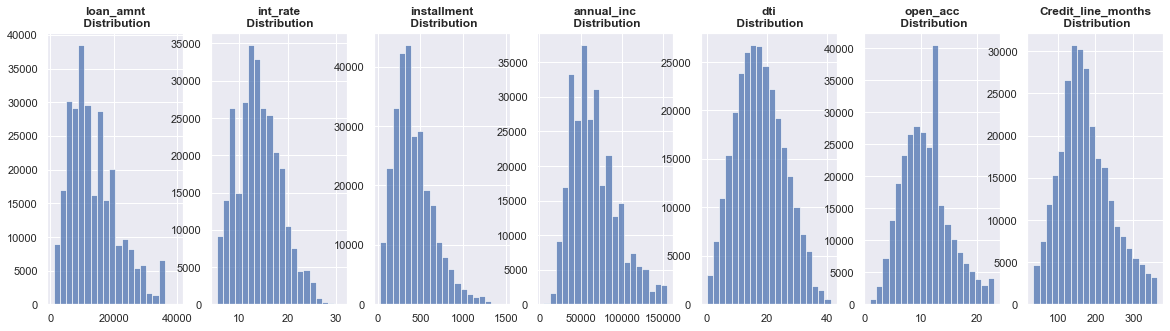

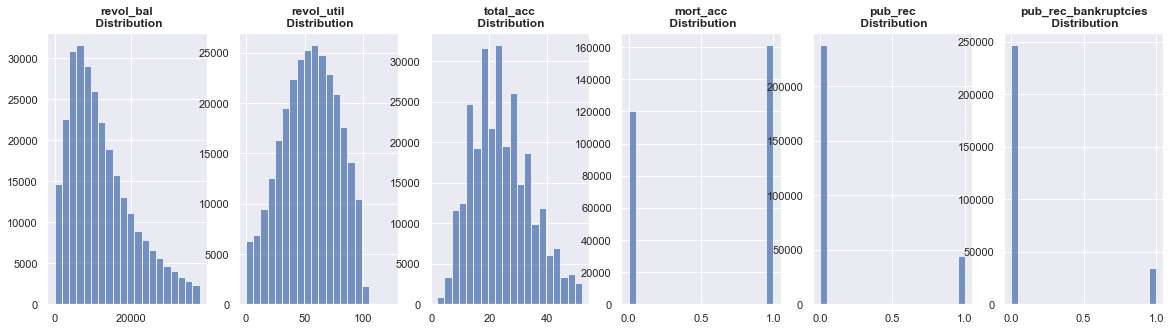

In [21]:
#Creating Histogram for all Continuous variable Columns in dataset
columns = hist_columns1
print('-'*70)
print('Univariate Analysis - Histograms of Continuous Variables')
print('-'*70)
plt.figure(figsize=(20,5))
for index, column in enumerate(columns):
    plt.subplot(1,len(columns),index+1)
    sns.histplot(x=column, data=data, bins = 20)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(column + '\n Distribution', fontsize = 12, fontweight = 'bold')
plt.show()

columns = hist_columns2
plt.figure(figsize=(20,5))
for index, column in enumerate(columns):
    plt.subplot(1,len(columns),index+1)
    sns.histplot(x=column, data=data, bins = 20)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(column + '\n Distribution', fontsize = 12, fontweight = 'bold')
plt.show()

----------------------------------------------------------------------
Univariate Analysis - Countplots of Categorical Columns
----------------------------------------------------------------------


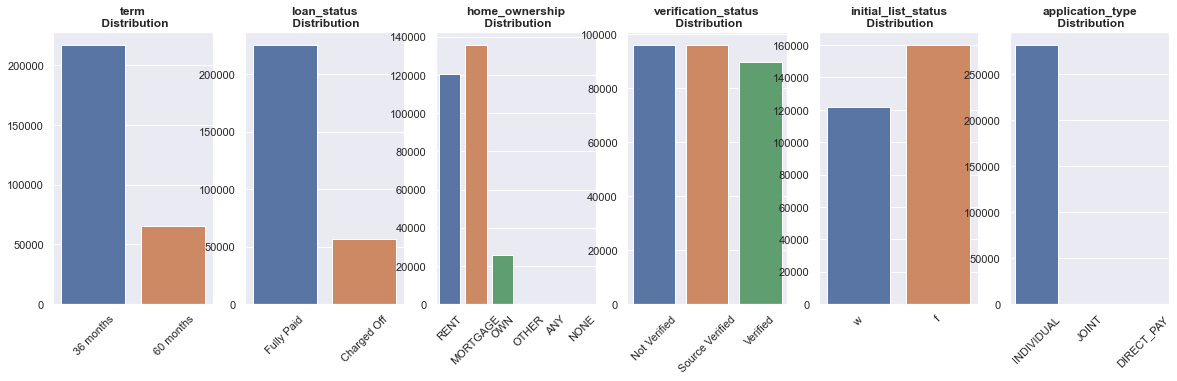

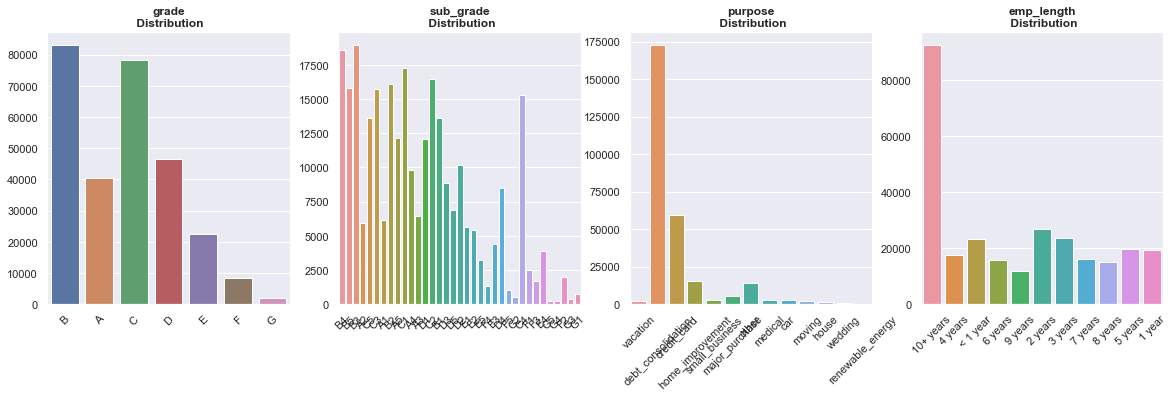

In [22]:
#Creating Countplot for all Categorical variable Columns in dataset
columns = countplot_columns1
print('-'*70)
print('Univariate Analysis - Countplots of Categorical Columns')
print('-'*70)
plt.figure(figsize=(20,5))
for index, column in enumerate(columns):
    plt.subplot(1,len(columns),index+1)
    sns.countplot(x=column, data=data)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.title(column + '\n Distribution', fontsize = 12, fontweight = 'bold')
plt.show()

columns = countplot_columns2
plt.figure(figsize=(20,5))
for index, column in enumerate(columns):
    plt.subplot(1,len(columns),index+1)
    sns.countplot(x=column, data=data)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.title(column + '\n Distribution', fontsize = 12, fontweight = 'bold')
plt.show()


### Bivariate Analysis & Correlation Matrix

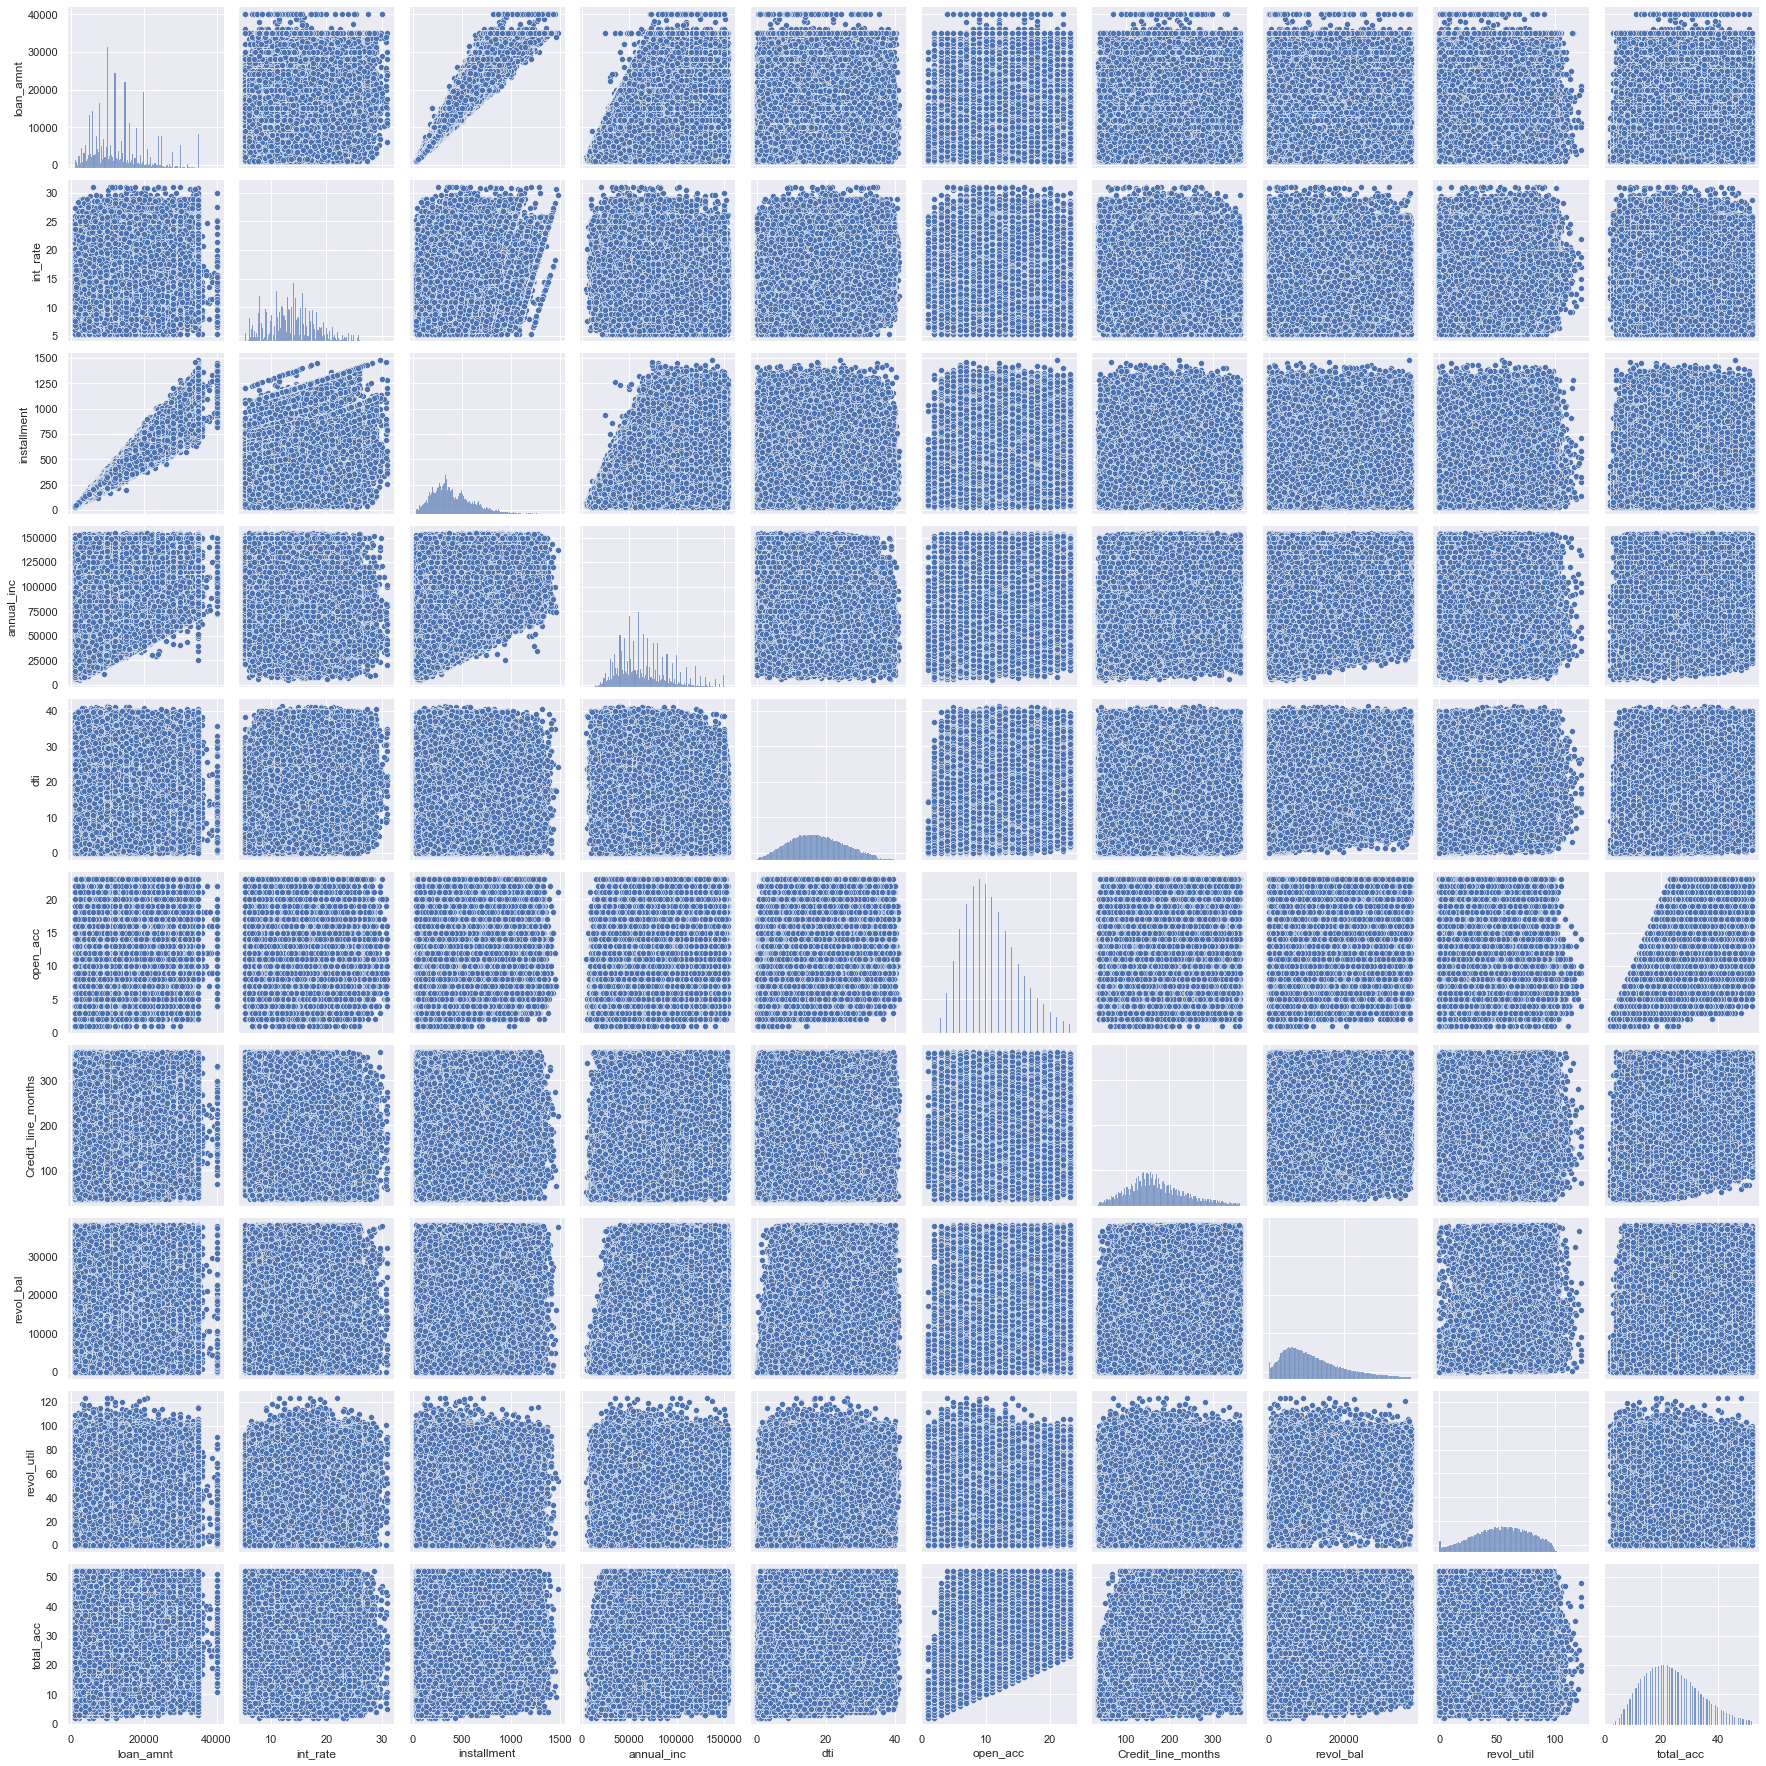

In [23]:
#Using PairPlot to plot scatter plots for all Numerical columns 
pairplot_columns = [item for item in hist_columns if item not in ['mort_acc', 'pub_rec', 'pub_rec_bankruptcies']]
sns.pairplot(data[pairplot_columns])
plt.show()

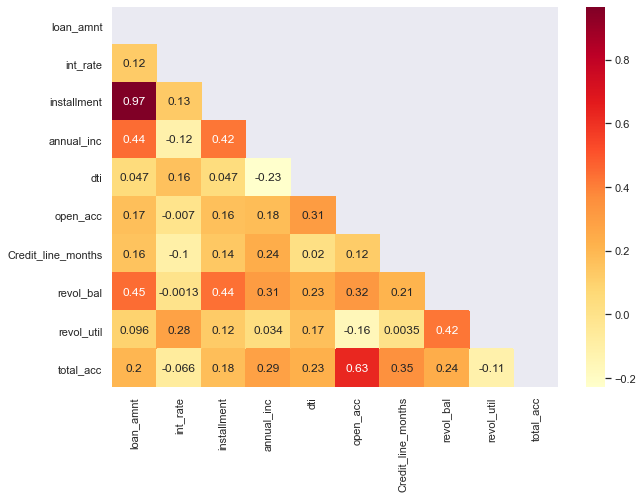

In [24]:
##Correlation Matrix
corr = data[pairplot_columns].corr(method='spearman')
mask = np.triu(corr)
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot = True, mask = mask, cmap = 'YlOrRd')
plt.show()

### Data Preprocessing

**One-Hot Encoding / Label Encoding of Categorical Variables**

In [25]:
data2 = data.copy(deep = True)

In [26]:
# Creating a dummy variable for each categorical variable and dropping the first one.
# Adding results to the master dataframe
# Dropping original column after creating dummies

# Column: term
term = pd.get_dummies(data2['term'],prefix='term',drop_first=True)
data2 = pd.concat([data2,term],axis=1)
data2 = data2.drop(columns=['term'])


# Column: grade
data2['grade'] = data2['grade'].map({'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : 6, 'G' : 7 })


# Column: sub_grade
data2['sub_grade'] = data2['sub_grade'].map({'A1' : 1.0, 'A2' : 1.2, 'A3' : 1.4, 'A4' : 1.6, 'A5' : 1.8, 
                                           'B1' : 2.0, 'B2' : 2.2, 'B3' : 2.4, 'B4' : 2.6, 'B5' : 2.8,
                                           'C1' : 3.0, 'C2' : 3.2, 'C3' : 3.4, 'C4' : 3.6, 'C5' : 3.8,
                                           'D1' : 4.0, 'D2' : 4.2, 'D3' : 4.4, 'D4' : 4.6, 'D5' : 4.8, 
                                           'E1' : 5.0, 'E2' : 5.2, 'E3' : 5.4, 'E4' : 5.6, 'E5' : 5.8, 
                                           'F1' : 6.0, 'F2' : 6.2, 'F3' : 6.4, 'F4' : 6.6, 'F5' : 6.8, 
                                           'G1' : 7.0, 'G2' : 7.2, 'G3' : 7.4, 'G4' : 7.6, 'G5' : 7.8, 
                                            })

# Column: emp_length
data2['emp_length'] = data2['emp_length'].map({'< 1 year': 0, '1 year': 1, '2 years' : 2, '3 years' : 3, '4 years' : 4, 
                                             '5 years': 5, '6 years': 6, '7 years' : 7, '8 years' : 8, '9 years' : 9,
                                             '10+ years': 10
                                            })


# Column: home_ownership
home_ownership = pd.get_dummies(data2['home_ownership'],prefix='home_ownership')
data2 = pd.concat([data2,home_ownership],axis=1)
data2 = data2.drop(columns=['home_ownership_NONE'])
data2 = data2.drop(columns=['home_ownership'])

# Column: verification_status
verification_status = pd.get_dummies(data2['verification_status'],prefix='verification_status',drop_first=True)
data2 = pd.concat([data2,verification_status],axis=1)
data2 = data2.drop(columns=['verification_status'])

# Column: loan_status
data2['loan_status'] = data2['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

# Column: purpose
purpose = pd.get_dummies(data2['purpose'],prefix='purpose', drop_first=True)
data2 = pd.concat([data2,purpose],axis=1)
data2 = data2.drop(columns=['purpose'])

# Column: initial_list_status
data2['initial_list_status'] = data2['initial_list_status'].map({'f': 1, 'w': 0})

# Column: application_type
application_type = pd.get_dummies(data2['application_type'],prefix='application_type')
data2 = pd.concat([data2,application_type],axis=1)
data2 = data2.drop(columns=['application_type_DIRECT_PAY'])
data2 = data2.drop(columns=['application_type'])

# Column: state
state = pd.get_dummies(data2['state'],prefix='state',drop_first=True)
data2 = pd.concat([data2,state],axis=1)
data2 = data2.drop(columns=['state'])

# Column : pincode
pincode = pd.get_dummies(data2['pincode'],prefix='pincode',drop_first=True)
data2 = pd.concat([data2,pincode],axis=1)
data2 = data2.drop(columns=['pincode'])


# Column : emp_title
emp_title = pd.get_dummies(data2['emp_title'],prefix='emp_title')
data2 = pd.concat([data2,emp_title],axis=1)
data2 = data2.drop(columns=['emp_title_Others'])
data2 = data2.drop(columns=['emp_title'])

# Column : title
title = pd.get_dummies(data2['title'],prefix='title')
data2 = pd.concat([data2, title],axis=1)
data2 = data2.drop(columns=['title_Others'])
data2 = data2.drop(columns=['title'])


In [27]:
data2.info()
#All columns converted to numerical columns after encoding

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281555 entries, 0 to 396028
Columns: 122 entries, loan_amnt to title_debt consolidation
dtypes: float64(10), int64(8), uint8(104)
memory usage: 78.7 MB


In [28]:
data2.describe(include = ['float64','int64'], percentiles=[.25,.5,.75,.90,.95, .99, .999]).round(2).T

count      mean       std      min       25%  \
loan_amnt             281555.0  13566.84   7738.27  1000.00   8000.00   
int_rate              281555.0     13.88      4.46     5.32     10.99   
installment           281555.0    417.58    230.71    28.75    253.86   
grade                 281555.0      2.86      1.31     1.00      2.00   
sub_grade             281555.0      3.26      1.30     1.00      2.40   
emp_length            281555.0      5.94      3.63     0.00      3.00   
annual_inc            281555.0  66028.74  28159.35  5000.00  45000.00   
loan_status           281555.0      0.80      0.40     0.00      1.00   
dti                   281555.0     17.59      8.02     0.00     11.59   
open_acc              281555.0     10.80      4.24     1.00      8.00   
pub_rec               281555.0      0.16      0.36     0.00      0.00   
revol_bal             281555.0  12339.83   8449.90     0.00   5852.00   
revol_util            281555.0     54.09     23.75     0.00     36.80   
total_acc             281555.0     23.90     10.08     2.00     16.00   
initial_list_status   281555.0      0.57      0.50     0.00      0.00   
mort_acc              281555.0      0.57      0.49     0.00      0.00   
pub_rec_bankruptcies  281555.0      0.12      0.33     0.00      0.00   
Credit_line_months    281555.0    173.36     68.44    36.00    126.00   

                           50%       75%        90%        95%        99%  \
loan_amnt             12000.00  18000.00   24925.00   29700.00   35000.00   
int_rate                 13.65     16.78      19.72      21.99      25.57   
installment             369.02    540.56     732.10     866.25    1155.14   
grade                     3.00      4.00       5.00       5.00       6.00   
sub_grade                 3.20      4.00       5.00       5.60       6.80   
emp_length                6.00     10.00      10.00      10.00      10.00   
annual_inc            60000.00  82000.00  105000.00  120000.00  147000.00   
loan_status               1.00      1.00       1.00       1.00       1.00   
dti                      17.13     23.21      28.64      31.62      36.21   
open_acc                 10.00     13.00      17.00      19.00      22.00   
pub_rec                   0.00      0.00       1.00       1.00       1.00   
revol_bal             10382.00  17105.00   25069.60   29778.30   35796.46   
revol_util               54.90     72.40      85.70      91.70      97.90   
total_acc                23.00     30.00      38.00      43.00      49.00   
initial_list_status       1.00      1.00       1.00       1.00       1.00   
mort_acc                  1.00      1.00       1.00       1.00       1.00   
pub_rec_bankruptcies      0.00      0.00       1.00       1.00       1.00   
Credit_line_months      164.00    215.00     272.00     306.00     349.00   

                          99.9%        max  
loan_amnt              35000.00   40000.00  
int_rate                  28.14      30.99  
installment             1295.74    1479.49  
grade                      7.00       7.00  
sub_grade                  7.60       7.80  
emp_length                10.00      10.00  
annual_inc            152000.00  154500.00  
loan_status                1.00       1.00  
dti                       39.57      41.25  
open_acc                  23.00      23.00  
pub_rec                    1.00       1.00  
revol_bal              37820.45   38042.00  
revol_util               102.20     123.30  
total_acc                 52.00      52.00  
initial_list_status        1.00       1.00  
mort_acc                   1.00       1.00  
pub_rec_bankruptcies       1.00       1.00  
Credit_line_months       362.00     363.00

## Model Building

**Train-Test Split & SMOTE** 

In [28]:
# Putting feature variable to X
X = data2.drop(columns = 'loan_status', axis = 1)

# Putting response variable to y
y = data2['loan_status']

In [29]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=23)

In [30]:
#Using SMOTE to balance the target variable
sm = SMOTE(random_state=23, k_neighbors=5)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [31]:
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_train_res))

Original dataset shape Counter({1: 180030, 0: 45214})
Resampled dataset shape Counter({1: 180030, 0: 180030})


In [32]:
# Splitting the Training data into training and validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23)

In [33]:
print(f'Shape of X_train : {X_train.shape} & shape of y_train is : {y_train.shape}')
print(f'Shape of X_val : {X_val.shape} & shape of y_val is : {y_val.shape}')
print(f'Shape of X_test : {X_test.shape} & shape of y_test is : {y_test.shape}')

Shape of X_train : (180195, 121) & shape of y_train is : (180195,)
Shape of X_val : (45049, 121) & shape of y_val is : (45049,)
Shape of X_test : (56311, 121) & shape of y_test is : (56311,)


**Feature Scaling** 

In [34]:
#identifying columns which need standardization
normalize_variables=['loan_amnt','open_acc','int_rate','installment','annual_inc','dti',
                     'revol_bal','revol_util','total_acc', 'Credit_line_months']

In [35]:
#standardization of relevant columns
scaler = StandardScaler()
X_train[normalize_variables] = scaler.fit_transform(X_train[normalize_variables])
X_test[normalize_variables] = scaler.transform(X_test[normalize_variables])
X_val[normalize_variables] = scaler.transform(X_val[normalize_variables])

#converting X from np.array to dataframes
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_val = pd.DataFrame(X_val, columns = X.columns)

**Calculating VIF scores and removing columns with high Multicolinearity**

In [36]:
vif_columns = normalize_variables
vif = pd.DataFrame()
vif['Features'] = vif_columns
vif['VIF'] = [variance_inflation_factor(X_train[vif_columns].values, i) for i in range(X_train[vif_columns].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0           loan_amnt  11.91
3         installment  11.24
1            open_acc   1.94
8           total_acc   1.92
6           revol_bal   1.88
4          annual_inc   1.58
7          revol_util   1.55
5                 dti   1.38
2            int_rate   1.23
9  Credit_line_months   1.20

In [37]:
#removing column loan_amnt and calculating vif again
vif_columns = ['open_acc','int_rate','installment','annual_inc','dti',
               'revol_bal','revol_util','total_acc', 'Credit_line_months']

vif = pd.DataFrame()
vif['Features'] = vif_columns
vif['VIF'] = [variance_inflation_factor(X_train[vif_columns].values, i) for i in range(X_train[vif_columns].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
0            open_acc  1.93
7           total_acc  1.91
5           revol_bal  1.83
3          annual_inc  1.56
6          revol_util  1.51
2         installment  1.47
4                 dti  1.38
1            int_rate  1.20
8  Credit_line_months  1.20

=> **Columns `loan_amnt` should be dropped for further analysis as they have high Multicolinearity (VIF values).**

In [38]:
#dropping column loan_amnt
X_train = X_train.drop(columns = 'loan_amnt', axis = 1)
X_test = X_test.drop(columns = 'loan_amnt', axis = 1)
X_val = X_val.drop(columns = 'loan_amnt', axis = 1)
normalize_variables=['open_acc','int_rate','installment','annual_inc','dti',
                     'revol_bal','revol_util','total_acc', 'Credit_line_months']

**Creating & Fitting RFE Model  + LogisticRegression Model to identify 20 Significant columns**

In [40]:
classifier = LogisticRegression(max_iter=1000)
rfe = RFE(classifier, n_features_to_select=20)
loan_model = rfe.fit(X_train.values, y_train)

In [41]:
print('-'*50)
print(f'20 Selected Significant Columns are as follow: ')
print('-'*50)
#print(X_train.columns[loan_model.support_])
sig_columns = X_train.columns[loan_model.support_]
for col in sig_columns:
    print(col)

--------------------------------------------------
20 Selected Significant Columns are as follow: 
--------------------------------------------------
int_rate
sub_grade
term_ 60 months
home_ownership_MORTGAGE
home_ownership_OTHER
purpose_renewable_energy
application_type_INDIVIDUAL
application_type_JOINT
pincode_05113
pincode_11650
pincode_22690
pincode_29597
pincode_30723
pincode_48052
pincode_70466
pincode_86630
pincode_93700
emp_title_Driver
emp_title_Owner
emp_title_Project Manager


In [42]:
lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train[sig_columns], y_train)

In [43]:
print('-'*70)
print(f'Accuracy of Logistic Regression Model is as follow:')
print(f'train_data: \t \t{np.round(model.score(X_train[sig_columns], y_train),5)*100} ')
print(f'val_data:\t \t{np.round(model.score(X_val[sig_columns], y_val),5)*100} ')
print(f'test_data:\t \t{np.round(model.score(X_test[sig_columns], y_test),5)*100} ') 
print('-'*70)

----------------------------------------------------------------------
Accuracy of Logistic Regression Model is as follow:
train_data: 	 	88.529 
val_data:	 	88.315 
test_data:	 	88.627 
----------------------------------------------------------------------


**Hyper-parameter Tunning: (c = 1/lambda)**

In [60]:
train_scores = []
val_scores = []

for la in np.arange(0.01, 10000, 100):
    lr1 = LogisticRegression(max_iter=1000, C= (1/la))
    model1 = lr1.fit(X_train[sig_columns], y_train)
    
    train_score = model1.score(X_train[sig_columns], y_train)
    val_score = model1.score(X_val[sig_columns], y_val)
    
    train_scores.append(train_score)
    val_scores.append(val_score)

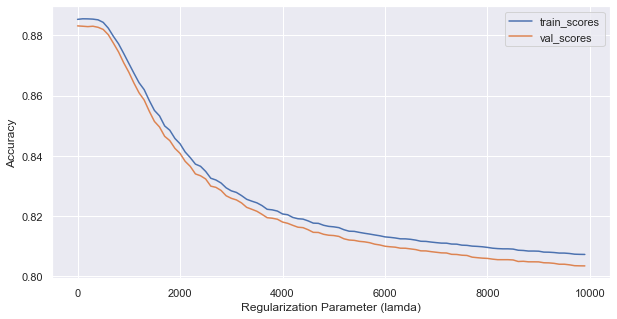

In [61]:
plt.figure(figsize=(10,5))
plt.plot(list(np.arange(0.01,10000, 100)), train_scores, label = 'train_scores')
plt.plot(list(np.arange(0.01,10000, 100)), val_scores, label = 'val_scores')
plt.xlabel( "Regularization Parameter (lamda)")
plt.ylabel ("Accuracy")
plt.legend()
plt.show()

=> **Hyperparameter tunning (i.e. increasing the value of lambda) is decreasing the overall accuracy of Model.**

=> **We will use the model with default value of lamda = 1.0 or C=1.0**

### ROC-AUC Curve

In [46]:
y_test_predict = model.predict_proba(X_test[sig_columns])
fpr, tpr, thr = roc_curve(y_test , y_test_predict[:,1])
auc_score = metrics.roc_auc_score( y_test, y_test_predict[:,1] )

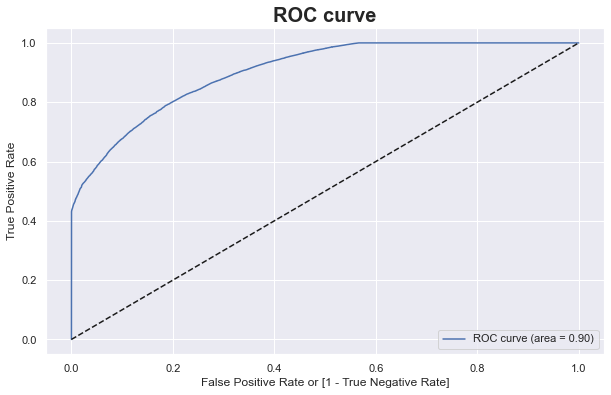

----------------------------------------------------------------------
ROC_AUC score = 0.903
----------------------------------------------------------------------


In [47]:
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve',  fontsize = 20, fontweight = 'bold')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('-'*70)
print(f'ROC_AUC score = {np.round(auc_score,3)}')
print('-'*70)

### Precision Recall Curve

In [48]:
precision, recall, thr = precision_recall_curve(y_test, y_test_predict[:,1])
pr_auc = auc(recall, precision)

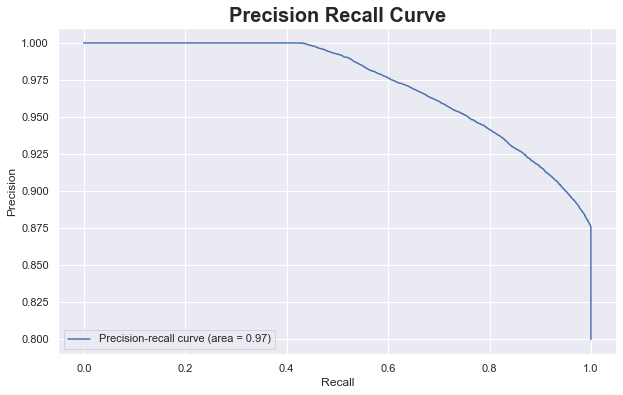

----------------------------------------------------------------------
PR_AUC score = 0.973
----------------------------------------------------------------------


In [49]:
plt.figure(figsize=(10,6))
plt.plot(recall, precision, label='Precision-recall curve (area = %0.2f)' % pr_auc)
#plt.plot([1, 0], [0, 1], 'k--')
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision Recall Curve',  fontsize = 20, fontweight = 'bold')
plt.legend(loc="lower left")
plt.show()
print('-'*70)
print(f'PR_AUC score = {np.round(pr_auc,3)}')
print('-'*70)

### Confusion Matrix

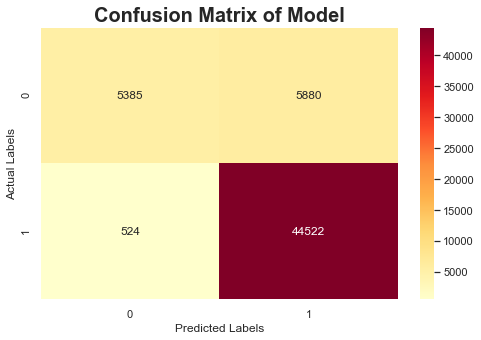

In [50]:
y_pred = model.predict(X_test[sig_columns])
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot = True, cmap = 'YlOrRd', fmt="1.0f")
plt.title('Confusion Matrix of Model',fontsize = 20, fontweight = 'bold' )
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [51]:
print('-'*70)
print(f'Classification Report of Logistics-Regression Model')
print('-'*70)
print(classification_report(y_test,y_pred))
print('-'*70)

----------------------------------------------------------------------
Classification Report of Logistics-Regression Model
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.48      0.63     11265
           1       0.88      0.99      0.93     45046

    accuracy                           0.89     56311
   macro avg       0.90      0.73      0.78     56311
weighted avg       0.89      0.89      0.87     56311

----------------------------------------------------------------------


Overall Statistics of the Model:

- **Accuracy = 89%**

- **Precision = 88%**

- **Recall = 99%**

- **F1 -score = 93%**

----------------------

1. Accuracy of the model is around 88%, which means model can predecit wheather a loan is going to be charged off or it will be fully paid correclty 88% times out of all the predictions.

2. Precision is showing us that when model predicted the loan to be fully paid and it got it right 88% of times. 12% predictions are wrongly classifed as fully paid loan when actully it was charged off loan (NPA will increase by 12%).

3. Recall is almost 99%, which means model predicted almost all the charged off loans correctly. There are very few False Negatives and hence not losing significant potential customers.

4. F1_score is 93% which means with a balance of precision and recall our model is performing well.

**14% of NPA will be bad for the business and it must be reduced. We can do this by adjusting the threshold level and
at cost of losing some potential customers.**



In [52]:
coefs = model.coef_.flatten()
feature_names = sig_columns

In [53]:
coef_df = pd.DataFrame(zip(feature_names, coefs), columns = ['feature', 'coefficient'])

In [54]:
coef_df = coef_df.sort_values('coefficient')

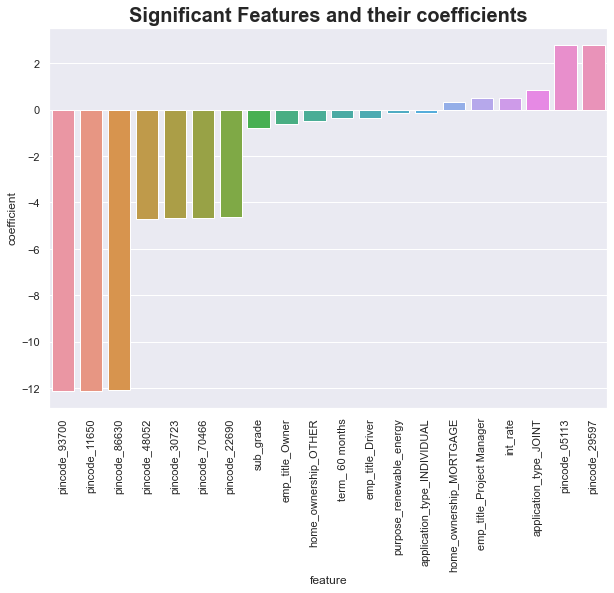

In [55]:
plt.figure(figsize=(10,7))
#coef_df.plot.bar(x='feature', y='coefficient')
sns.barplot(data = coef_df, x='feature', y='coefficient')
#plt.ylabel('')
#plt.xlabel('')
plt.xticks(rotation=90)
plt.title('Significant Features and their coefficients', fontsize = 20, fontweight = 'bold')

plt.show()

In [7]:
y_test

NameError: name 'y_test' is not defined

## Questions

**1. How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.**

=> To keep very less False Positives, oversampling techniques like SMOTE should be used in model creation. Also we can use more complex algorithms like SVM, Decision-Trees, Random Forest and also try various hyperparameter tunning. 

=> As you can see from the data, the percentage of defaulters is slightly higher than Banking industry.

-------------------

**2. Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.**

=> Yes. LoanTap should not disburse loans to everyone. Company's internal policy and analysis should be in place to identify the correct persons. From data provided, 20% of people default on their loan, which inturn become NPAs for the company.

=> Low False positive means we should create the model with high Precision values. This can be achieved if we are keeping high threshold value in logistic Regression model.

=> But keeping too high values for threshold will increase False Negatives. This in turn may result in opportunity loss. In this case we will not give loans to persons which will not default but our model has predicted that they will default. .

-------------------

**3. What percentage of customers have fully paid their Loan Amount?**

=> Around 80.26% of customers have fully paid their Loan Amount.

-------------------

**4. Comment about the correlation between Loan Amount and Installment features.**

=> The spearman correlation coefficient between `Loan Amount` and `Installment` is very high (i.e. 0.97).

=> This indicates high multicollinearity between these two features. This in turn resulted in high VIF value (i.e. 11.91). 

=> Because of this HIGH VIF value, column `Loan Amount` was dropped in creating model.

-------------------

**5. The majority of people have home ownership as _______.**

=> Majority of people have home_ownership = `MORTAGE`. This is about 50%. 

=> Next highest is `RENT` (~40%)



In [56]:
raw_data['home_ownership'].value_counts(normalize=True)

MORTGAGE    0.500841
RENT        0.403480
OWN         0.095311
OTHER       0.000283
NONE        0.000078
ANY         0.000008
Name: home_ownership, dtype: float64

-------------------
**6. People with grades ‘A’ are more likely to fully pay their loan. (T/F)**

=> True. 

=> Out of all people with grade 'A', 93% got their loan approved.

In [57]:
raw_data.loc[raw_data['grade'] == 'A' ,'loan_status'].value_counts(normalize=True)

Fully Paid     0.937121
Charged Off    0.062879
Name: loan_status, dtype: float64

-------------------

**7. Name the top 2 afforded job titles.**

=> `Teacher` & `Manager`

In [58]:
raw_data['emp_title'].value_counts(normalize=True).head()

Teacher             0.011764
Manager             0.011391
Registered Nurse    0.004974
RN                  0.004948
Supervisor          0.004905
Name: emp_title, dtype: float64

-------------------

**8. Thinking from a bank's perspective, which metric should our primary focus be on..**<br>
**1.	ROC AUC**<br>
**2.	Precision**<br>
**3.	Recall**<br>
**4.	F1 Score**<br>

=> The best metric to consider is `F1 score` as we need to give importance to both precision and recall. We don't want to miss potential customers and at the same time we also don't want to give loan to defaulters

-------------------
 

**9. How does the gap in precision and recall affect the bank?**

=> Recall score: 0.99 and Precision score: 0.88. Which tells us that there are more false positives than the false negatives.

=> From Confusion Matrix it can be seen that FP = 10% of total cases & FN = 0.9% of Total Cases

=> If Recall value is low (i.e. FN are high), it means Bank is loosing in opportunity cost.

=> If Precision value is low (i.e. FP are high), it means Bank's NPA (defaulters) may increase.

-------------------

**10. Which were the features that heavily affected the outcome?**

=> Using RFE we were able to identify top_20 features which has high impact on Outcome. This include: <br>
1. int_rate: Interest Rate <br>
2. sub_grade: loan subgrade <br>
3. term : number of payments on the loan
4. home_ownership 
5. purpose
6. application_type
7. pincode (from address)
8. emp_title: job title supplied by the Borrower 

In [59]:
for col in sig_columns: print(col)

int_rate
sub_grade
term_ 60 months
home_ownership_MORTGAGE
home_ownership_OTHER
purpose_renewable_energy
application_type_INDIVIDUAL
application_type_JOINT
pincode_05113
pincode_11650
pincode_22690
pincode_29597
pincode_30723
pincode_48052
pincode_70466
pincode_86630
pincode_93700
emp_title_Driver
emp_title_Owner
emp_title_Project Manager


-------------------

**11. Will the results be affected by geographical location? (Yes/No)**

=> Yes.

=> pincode (derived from address) has significant impact on the outcome.

-------------------

## Actionable insights and recommendations

- Around **80.26%** of customers have fully paid their Loan Amount. The defaulters are **~ 20%**. From Personal loan business perspective this ratio is high. These 20% will contribute in NPAs of LoanTap. To reduce the risk of NPAs,
    - LoanTap should add slightly stringent rules to bring down this ratio to 5% to 6%. 
    - LoanTap should provide loans at slightly higher rate than other Banks. This will offset the risks of defaulters and maintain the profitability of the business.


- Overall Statistics of the Model:
    - **Accuracy = 89%**
    - **Precision = 88**
    - **Recall = 99**
    - **F1 -score = 93%**

- Model created has high values for accuracy, precision, recall & f1-score. This means, this model is a good classifier. Overall, it has good prediction capability in identifying right customers (which can be easily converted).
    - However this model has slightly low capability on correctly identifying defaulters. Overall data has 20% defaulters, model is able to predict 10% of them correctly.
    - Using this model, LoanTap can easily reduce the ration of defaulters in their portfolio.
   

-  **Features which have significant impact on outcome are as follow**: <br>
    1. int_rate: Interest Rate <br>
    2. sub_grade: loan subgrade <br>
    3. term : number of payments on the loan
    4. home_ownership 
    5. purpose
    6. application_type
    7. pincode (from address)
    8. emp_title: job title supplied by the Borrower 
    

- **sub_grade** and **grade** logic to classify persons by LoanTap is well created. From the model it is considered to be significant.

- **pincode** is significant feature. 
    - Pincodes with Negative Coefficient: 93700, 11650, 86630, 48052, 30723, 70466, 22690
    - Pincodes with Positive Coefficient: 05113, 29597
    - LoanTap can increase their market presence in pincodes with Positive Coefficient. 
    - LoanTap should minimize their marketing/sales expenditure in pincodes with Negative Coefficient.
    - Pincode based market segmentation should be included at strategic levels.
    
- **emp_title** Owner & Driver has negative Coefficient. emp_title  Project Manager has positive Coefficient. LoanTap can also decide their social media based marketing based on person's job-titles.

- Application_type JOINT has positive Coefficient. Which means LoanTap can promote persons to apply for joint loan. Because of this, chances of default will reduce.

- Purpose Renewable energy has negative Coefficient. This means LoanTap should stick to giving loans to conventional purposes like Marriage, car etc.

- term 60 months has negative Coefficient. Which means LoanTap should focus more on Loans for shorter duration (i.e. 36 months). Their social media campaign and marketing strategy should be based on this consideration.

### ------------------------------ End ------------------------------